# BiRNN Implementation
Author: Sara Hoxha

In [29]:
import pandas as pd
import torch
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras import regularizers
import keras_tuner as kt
import keras
from tensorflow.keras.utils import to_categorical, pad_sequences

In [30]:
import os
import sys

original_sys_path = sys.path.copy()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../general_utils'))
sys.path.append(parent_dir)

from preprocessing import *
from metrics_plot_utils import *
sys.path = original_sys_path

# Yangswei_85

To use the Yangswei_85 dataset, run the cell below.

In [31]:
# Load training set
df_train = pd.read_csv('data/train_yangswei_85.csv')  
# Load test set
test_df = pd.read_csv('data/test_yangswei_85.csv')
dataset_name = 'Yangswei_85'

# T5 
To use the T5 dataset, run the cell below.

In [21]:
# Load training set
df_train = pd.read_csv('data/train_t5.csv')  
# Load test set
test_df = pd.read_csv('data/test_t5.csv')
dataset_name = 'T5'

# Training and Validation

## Training Data Preprocessing

Firstly, we apply preprocessing (fixing contractions, setting all text to lowercase, removing non-alphanumeric characters) to the training text.

Secondly, we tokenize and pad the training text using TensorFlow Keras TextVectorization. To reuse the tokenizer during the testing preprocessing, we save the tokenizer in a pickle file.

Lastly, we encode the labels of the training dataset and save them to a npy file called 'label_classes.npy'.

In [32]:
#Preprocess training data
df_train['text'].apply(preprocess).to_frame()

# Tokenize and pad training data
padded_sequences, tokenizer, vocab_size = tokenize_and_pad(df_train[['text']])

#Save tokenizer in a pickle file to reuse
with open(f'data/tokenizers/tokenizer_birnn_{dataset_name}.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Set training data
padded_train_data = padded_sequences

#Encode labels and save classes in npy file
label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])
np.save('data/label_classes.npy', label_encoder.classes_)
train_labels = torch.tensor(label_encoder.transform(df_train['label']),dtype=torch.long)
num_classes = len(label_encoder.classes_)
train_labels_one_hot_encoded = to_categorical(train_labels)

## Define BiRNN model & Tune Hyperparameters
In the cell below, we define and tune a Bidirectional Recurrent Neural Network (BiRNN) model using Keras Tuner's Random Search. More specifically, it will be a BiLSTM to handle the vanishing gradient problem of RNN.

In [23]:
#Define architecture of BiRNN
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Choice('output_dim', [128])))#64, 128
    # Set an adjustable number of LSTM layers (max 2)
    num_layers = hp.Int('num_layers', min_value=1, max_value=1, step=1) #1, 2
    for i in range(num_layers):
        units = hp.Int(f'lstm_units_{i}', min_value=32, max_value=80, step=16) #32, 128, 32
        model.add(
            Bidirectional(
                LSTM(
                    units, 
                    return_sequences=(i < num_layers - 1),
                    kernel_regularizer=regularizers.l2(6e-3) #1e-3
                )
            )
        )
        # Dropout for regularization
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.4, max_value=0.6, step=0.1))) # 0.2,  0.5, 0.1
    # Output layer for classification
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#Create a keras tuner to find the best hyperparameters
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,  #25
    executions_per_trial=1

)

#Search for the best hyperparameters
tuner.search(padded_train_data, train_labels_one_hot_encoded, epochs=15, validation_split=0.2, batch_size=32)

#Get the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

Reloading Tuner from ./untitled_project/tuner0.json
Best hyperparameters: {'output_dim': 128, 'num_layers': 1, 'lstm_units_0': 48, 'dropout_rate_0': 0.4}


## Train and Validate best model

In the cell below, we conduct the training and validation of the tuned BiRNN model. We set two callbaks (Checkpoint & Early Stopping) to save the best model based on validation loss and stop training if the validation loss does not improve for a specified number of epochs (15) respectively. The traing and validation losses are extracted from the training history and plotted.

In [ ]:
print("Start Training and Validation:\n")
epochs = 50
patience = 15
batch_size = 64

#Build BiRNN model using best hyperparameters
birnn_model = build_model(best_hps)
#Set path for best model
best_model_file_name = f'models/best_birnn_model_{dataset_name}.keras'
#Set callbacks
model_checkpoint = ModelCheckpoint(best_model_file_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
callbacks= [model_checkpoint, early_stopping]

#Train BiRNN model
history = birnn_model.fit(
    padded_train_data, 
    train_labels_one_hot_encoded, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    callbacks=callbacks, 
    verbose=1
)

# Extract training and validation losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']
actual_epochs =  len(train_losses)

# Plot training and validation losses
plot_losses("BiRNN", dataset_name, train_losses, val_losses, actual_epochs, f'results/BiRNN/training_losses_birnn_{dataset_name}.png')


Start Training and Validation:

Epoch 1/50
  75/1115 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.5559 - loss: 2.6813

# Test

## Test Data Preprocessing
Here we conduct the same preprocessing to the test data as done for the training data, using also the same tokenizer which we load from the saved pickle file.

In [25]:
# Preprocess test data
test_df['text'].apply(preprocess).to_frame()  

#Load tokenizer used in training
with open(f'data/tokenizers/tokenizer_birnn_{dataset_name}.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Tokenize and pad test data using the same tokenizer from training
sequences = tokenizer(test_df['text'])
padded_test_sequences = pad_sequences(sequences, maxlen=padded_train_data.shape[1], padding="post", truncating="post")

# Set test data
test_data = padded_sequences

#Encode test labels by loading encoder used for training labels
true_labels = test_df['label']
label_classes = np.load('data/label_classes.npy', allow_pickle=True)
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes
test_labels = torch.tensor(label_encoder.transform(true_labels))
test_labels_one_hot_encoded = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

## Test best model on test data

In [26]:
# Load the saved model
best_model_file_name = f'models/best_birnn_model_{dataset_name}.keras'
model = tf.keras.models.load_model(best_model_file_name)

#Test model
test_loss, test_accuracy = model.evaluate(padded_test_sequences, test_labels_one_hot_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

#Extract predictions and probabilities
predictions_probabilities = model.predict(padded_test_sequences)
predicted_classes = label_encoder.inverse_transform(np.argmax(predictions_probabilities, axis=1))
#Decode true labels
true_classes = label_encoder.inverse_transform(np.argmax(test_labels_one_hot_encoded, axis=1))

765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7364 - loss: 0.7104
Test Loss: 0.7181, Test Accuracy: 0.7324
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


## Compute metrics on model performance

/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics Dictionary saved to results/BiRNN/metrics_birnn_T5.txt
Test Accuracy: 0.7324


Macro Metrics
Macro Precision: 0.5801
Macro Recall: 0.5342
Macro F1 Score: 0.5451


Weighted Metrics
Weighted Precision: 0.7392
Weighted Recall: 0.7324
Weighted F1 Score: 0.7305


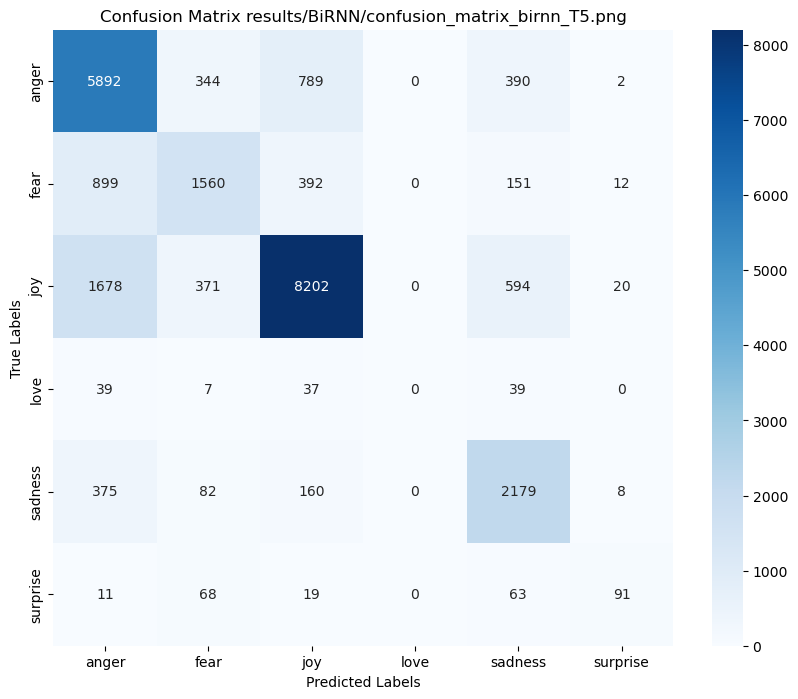

In [27]:

# Compute metrics
metrics = compute_metrics(predicted_classes, true_classes, f'results/BiRNN/metrics_birnn_{dataset_name}.txt')
print(f"Test Accuracy: {metrics['accuracy']:.4f}")
print('\n')
print('Macro Metrics')
print(f"Macro Precision: {metrics['precision']:.4f}")
print(f"Macro Recall: {metrics['recall']:.4f}")
print(f"Macro F1 Score: {metrics['f1']:.4f}")
print('\n')
print('Weighted Metrics')
print(f"Weighted Precision: {metrics['precision_weighted']:.4f}")
print(f"Weighted Recall: {metrics['recall_weighted']:.4f}")
print(f"Weighted F1 Score: {metrics['f1_weighted']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, label_classes, f'results/BiRNN/confusion_matrix_birnn_{dataset_name}.png')

In [28]:

# Print classification report
print('Classification Report:\n')
print(classification_report(true_classes, predicted_classes, target_names=label_classes))


Classification Report:

              precision    recall  f1-score   support

       anger       0.66      0.79      0.72      7417
        fear       0.64      0.52      0.57      3014
         joy       0.85      0.75      0.80     10865
        love       0.00      0.00      0.00       122
     sadness       0.64      0.78      0.70      2804
    surprise       0.68      0.36      0.47       252

    accuracy                           0.73     24474
   macro avg       0.58      0.53      0.55     24474
weighted avg       0.74      0.73      0.73     24474



/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/txa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
